In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
import numpy as np
import matplotlib

In [133]:
# 数据初始化
person = 'B'
num = 10
category = '单个个体'

# 阈值
threshold = 25

delete_list = ['Yindel', 'AMEL', 'DYS391', 'Amel']
reference = pd.read_csv('data/Refrence.csv')
# 计算每个个体的基因座上的等位基因
A_refrence_data = reference[reference['sample'] == person]
A_refrence_data = A_refrence_data[~A_refrence_data['marker'].isin(delete_list)]
alleles_dict = {A_refrence_data['marker']:[A_refrence_data['allele1'],A_refrence_data['allele2']] for index,A_refrence_data in A_refrence_data.iterrows()}


init_data = pd.read_csv(f'data/{category}/{person}{num}pg.hid_Genotype.csv', usecols=['Marker', 'Allele', 'Height', 'Size'], dtype={"Allele": str})
init_data = init_data[(init_data['Size'] != 'Dropout') & ~(init_data['Marker'].isin(delete_list))]
init_data['Height'] = init_data['Height'].apply(pd.to_numeric, errors='coerce').fillna(0.0)


stutter = {}
# 遍历alleles_dict
for key, value in alleles_dict.items():
    new_list = []
    for i in value:
        new_list.append(float(i)-1)
    stutter[key] = new_list

# 阴性对照
negative_data = pd.read_csv('data/阴性对照NC.hid_Genotype.csv', usecols=['Marker', 'Allele', 'Height', 'Size'])
negative_data = negative_data[(negative_data['Size'] != 'Dropout') & ~(negative_data['Marker'].isin(delete_list))]
negative_data['Height'] = negative_data['Height'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
negative_data


,Marker,Allele,Size,Height
0,D3S1358,9,97.07,10.0
1,D3S1358,10,100.71,17.0
2,D3S1358,11,104.97,8.0
3,D3S1358,12,108.51,14.0
4,D3S1358,13,112.75,10.0
...,...,...,...,...
338,D2S1338,24,333.64,34.0
339,D2S1338,25,337.48,18.0
340,D2S1338,26,341.81,26.0
341,D2S1338,27,345.15,15.0


In [134]:
# 1. 噪声过滤
remain_data = init_data[init_data['Height'] >= threshold]

# 2. 真实基因剔除
for key, value in alleles_dict.items():
    remain_data = remain_data.drop(remain_data[(remain_data['Marker'] == key) & ((remain_data['Allele'] == value[0]) | (remain_data['Allele'] == value[1]))].index)

# 3. 删去真实等位基因 -1 的峰
for key, value in stutter.items():
    remain_data = remain_data.drop(remain_data[(remain_data['Marker'] == key) & ((remain_data['Allele'] == value[0]) | (remain_data['Allele'] == value[1]))].index)


# 4. 减去阴性对照峰值
# 遍历remain_data
for index, row in remain_data.iterrows():
    for key, value in negative_data.iterrows():
        if row['Marker'] == value['Marker']:
            if str(row['Allele']) == value['Allele']:
                remain_data.loc[index, 'Height'] = row['Height'] - value['Height']

print(remain_data.head())

     Marker Allele    Size  Height
7   D3S1358     16  125.11    61.0
17      vWA     16  176.73    17.0
19      vWA     18  184.88    22.0
30  D16S539     11  252.53    20.0
40   CSF1PO     11  303.44    23.0


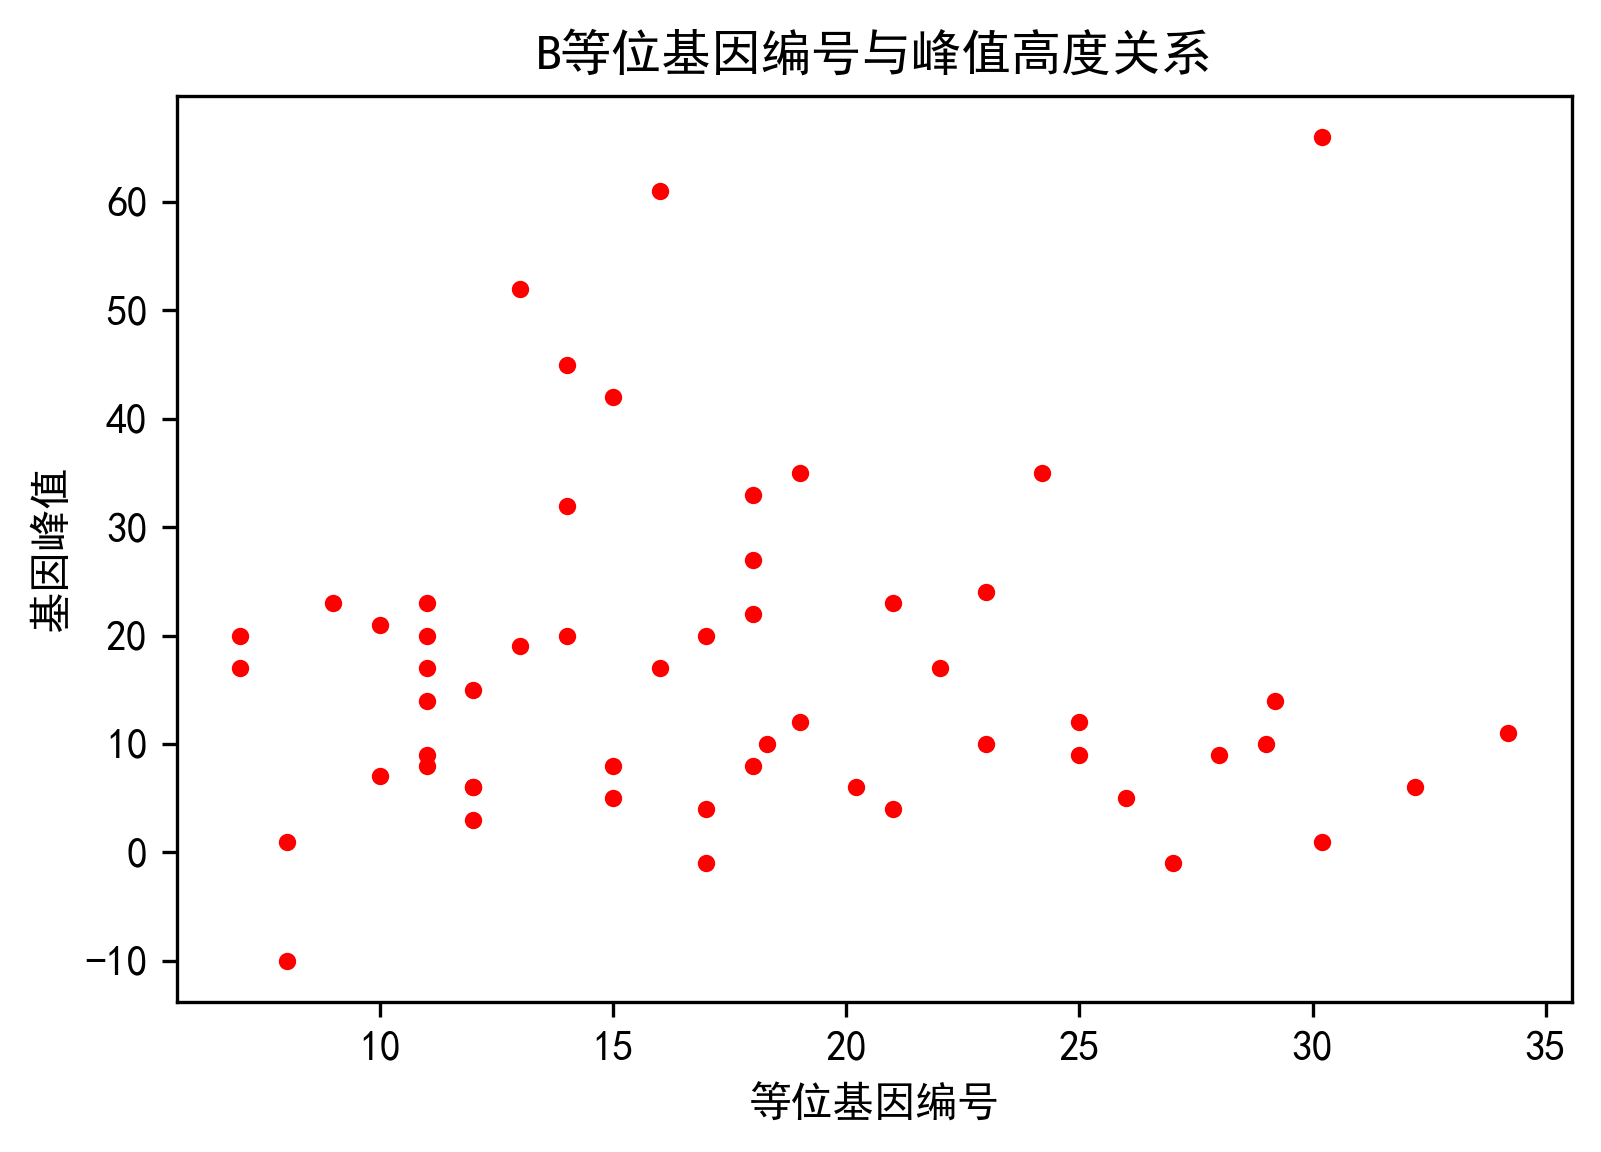

In [135]:
x = remain_data['Allele'].astype(float).tolist()
y = remain_data['Height'].astype(float).tolist()
x_norm = Normalizer(norm='l2').fit_transform(np.array(x, dtype='float32').reshape(1, -1))
y_norm = Normalizer(norm='l2').fit_transform(np.array(y, dtype='float32').reshape(1, -1))
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif' #解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
plt.figure(dpi=300)
plt.title(f'{person}等位基因编号与峰值高度关系')
plt.xlabel('等位基因编号')
plt.ylabel('基因峰值')

plt.scatter(x, y, s=10, c='r', marker='o')

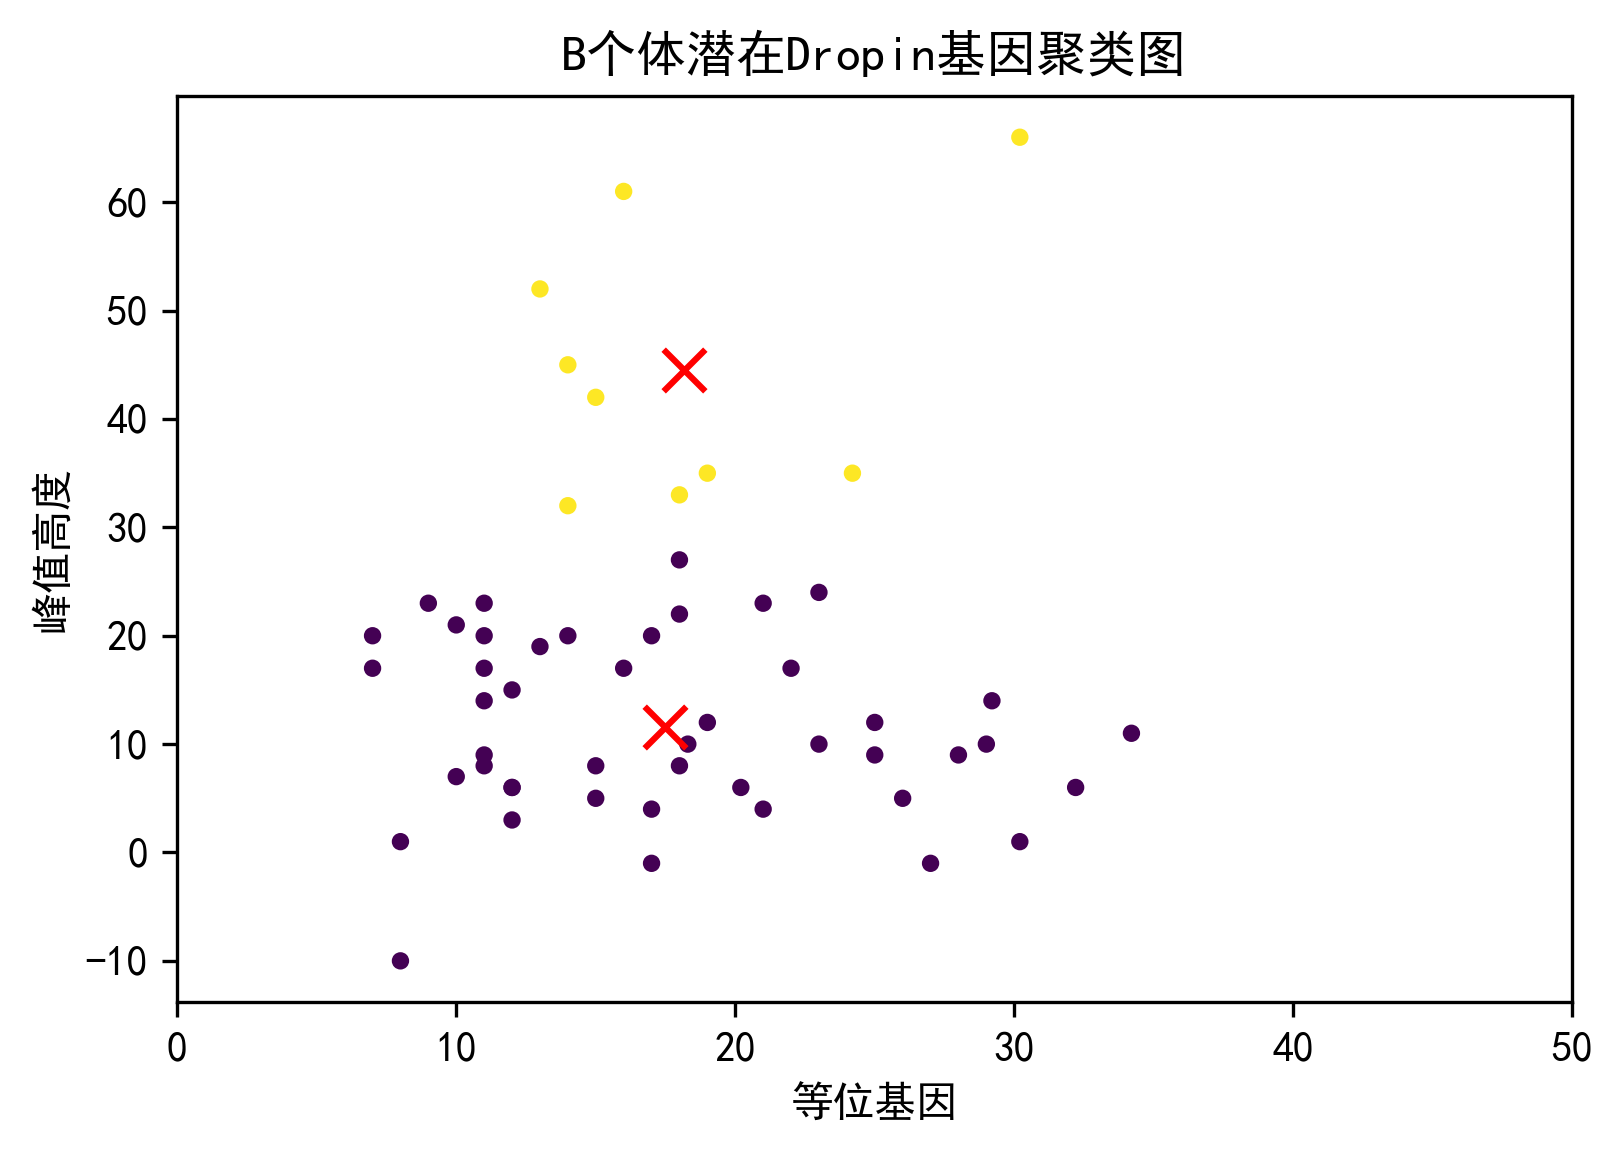

In [136]:
from sklearn.cluster import KMeans

k_means_list = []
# numpy 将列表x与y, 转化为二维矩阵
for i in range(len(x)):
    k_means_list.append([x[i], y[i]])

# 设置为三个聚类中心
Kmeans = KMeans(n_clusters=2, algorithm='full',)
# 训练模型
Kmeans.fit(np.array(k_means_list))
plt.figure(dpi=300)
plt.title(f'{person}个体潜在Dropin基因聚类图')
plt.xlabel('等位基因')
plt.ylabel('峰值高度')
plt.xlim(0, 50) 
plt.scatter(x, y,s=10, c=Kmeans.labels_, marker='o')
Kmeans.cluster_centers_
plt.scatter(Kmeans.cluster_centers_[:, 0], Kmeans.cluster_centers_[:, 1], s=100, c='r', marker='x')
# with open(f'img/{person}潜在Dropin聚类图.png','wb') as f:  
#     plt.savefig(f, format='png', dpi=300)

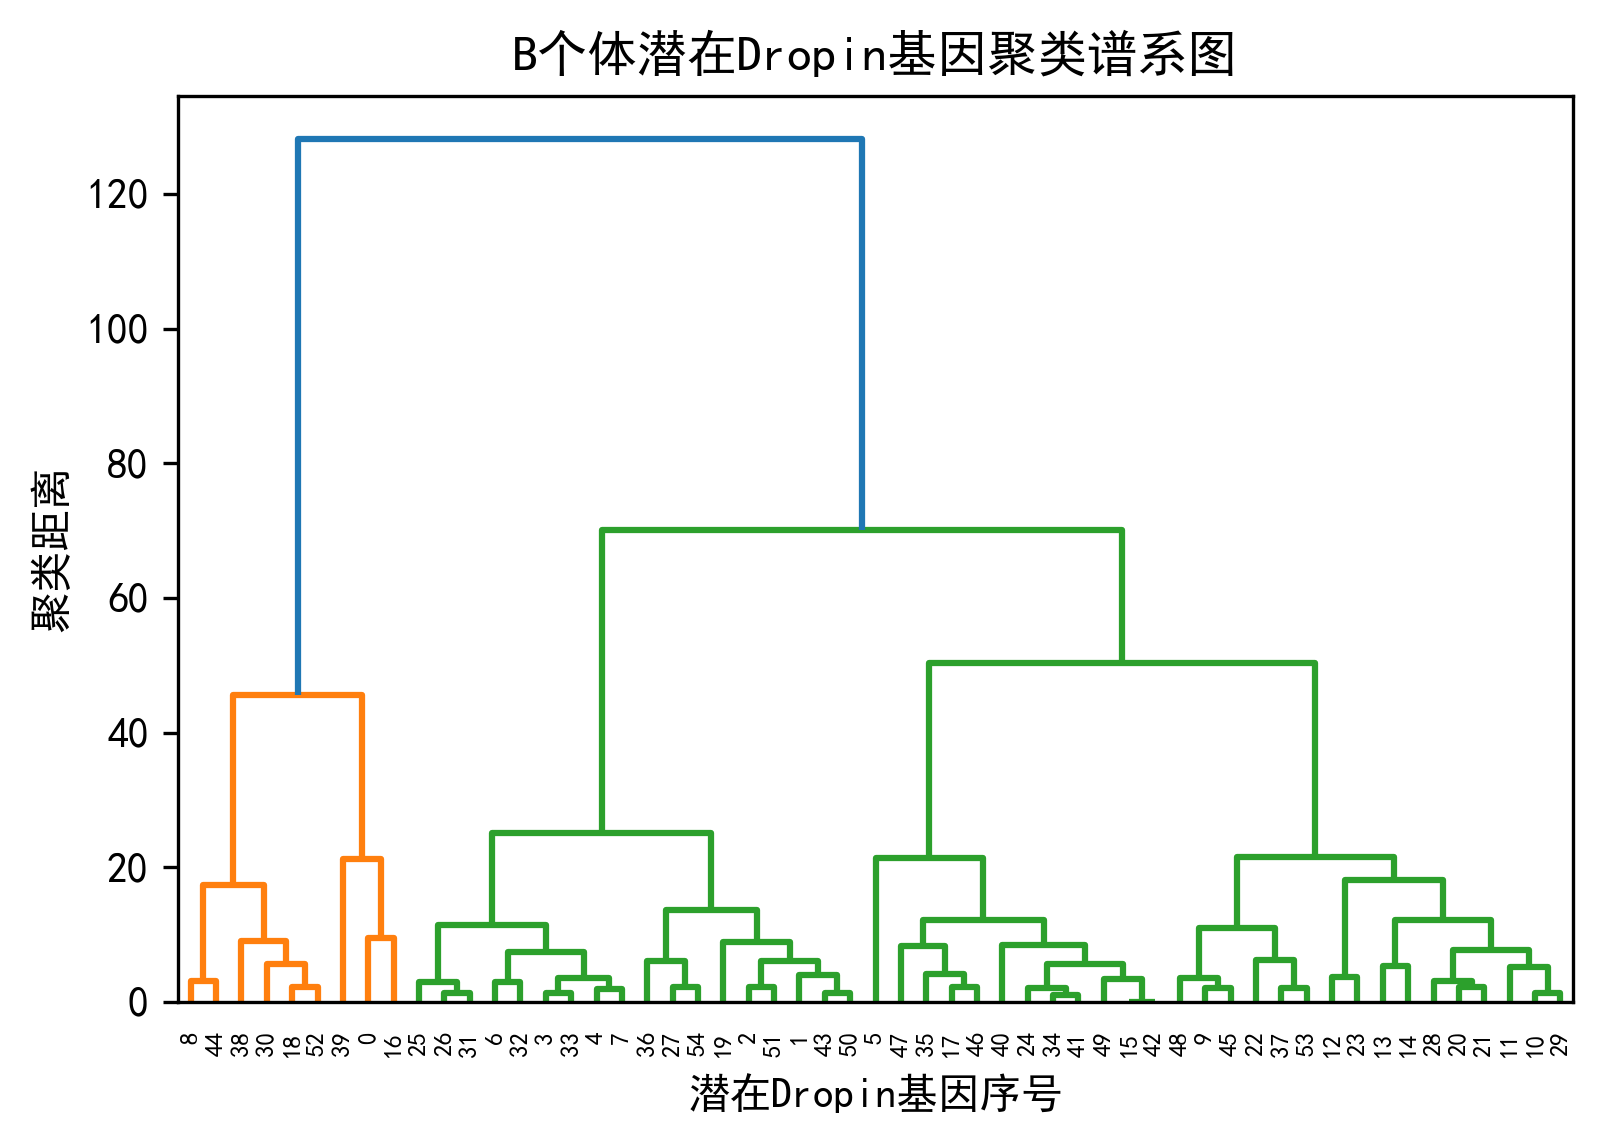

In [137]:
# 从SciPy中导入dendrogram函数和ward聚类函数
from scipy.cluster.hierarchy import dendrogram, ward

# 将ward聚类应用于数据数组X
# SciPy的ward函数返回一个数组，指定执行凝聚聚类时跨越的距离
linkage_array = ward(np.array(k_means_list))

plt.figure(dpi=300)
plt.title(f'{person}个体潜在Dropin基因聚类谱系图')
plt.xlabel('潜在Dropin基因序号')
plt.ylabel('聚类距离')
# 现在为包含簇之间距离的linkage_array绘制树状图
dendrogram(linkage_array)
with open(f'img/{person}潜在Dropin聚类谱系图.png','wb') as f:  
    plt.savefig(f, format='png', dpi=300)